## Time Frequency analysis for RQ 3 - Not equalized:

The hypothesis to be tested is:

There are effects of successful recognition of old images (i.e., a difference between
old images correctly recognized as old [hits] vs. old images incorrectly judged as new
[misses])  on spectral power, at any frequencies, at any channels, at any time.



In [2]:
import mne
import pandas as pd
import scipy.io
import os
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from os.path import join as opj
from glob import glob
from numpy.random import randn 
from mne.time_frequency import tfr_morlet, write_tfrs
from mne.epochs import equalize_epoch_counts
from scipy.stats import spearmanr, ttest_ind, describe, normaltest, pearsonr
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test
import time
from mne.viz import plot_tfr_topomap

def ensure_dir(ed):
    import os
    try:
        os.makedirs(ed)
    except OSError:
        if not os.path.isdir(ed):
            raise


In [4]:
'''
load epoched and autorejected data
'''

# starting from a relative path /eeg_BIDS which you should also have
bids_root = '../eeg_BIDS/'
prepro_root = '../Preprocessed/'

subs = [ name for name in os.listdir(bids_root) if name.startswith('sub') ]

#=========================================================================
# === just for initiating some params, I need to read one epoch to fill them out
logged_freqs=np.logspace(np.log10(4),np.log10(40),18)

n_cycles = logged_freqs / 2.

decim = 1 # specify decimation factor - decimation occors after TFR estimation

njobs = 10
n_subj = len(subs)
n_freqs      = len(logged_freqs)
power_all    = dict();itc_all     = dict()#[subj * chan * freqs * time]
power_avgAll = dict(); itc_avgAll = dict()#[chan * freqs * time]

subject=subs[0]
epochs_RQ3 = mne.read_epochs(glob(opj(prepro_root,subject,subject+'*old_hit*epo.fif'))[0],
                             preload=True,
                             verbose='error')
epochs_RQ3.decimate(decim)


# preallocate matrices
n_epochs, n_chan, n_times = epochs_RQ3.pick_types(eeg=True).crop(0, 0.5).get_data().shape
power_all_subj_old_hit = randn(n_subj, n_chan, n_freqs, n_times) * 0

n_epochs, n_chan, n_times = epochs_RQ3.pick_types(eeg=True).crop(0, 0.5).get_data().shape
power_all_subj_old_miss = randn(n_subj, n_chan, n_freqs, n_times) * 0


"""
==============================================================================
    Read all subject
    Apply tfr_morlet
==============================================================================
"""
subj_num_id=0

# loop over subjects to transform to the time-frequency domain

for subject in subs:
    print(subject)
    '''
    epochs_old_hit
    '''
    #picks = mne.pick_channels(raw.info["ch_names"], ["C3", "Cz", "C4"]) # In case specific channels are to be picked - also need to add the picks parameter to the next function
    epochs_old_hit = mne.read_epochs(glob(opj(prepro_root,subject,subject+'*old_hit*epo.fif'))[0],
                                     preload=True,
                                     verbose='error')
    
    epochs_old_miss = mne.read_epochs(glob(opj(prepro_root,subject,subject+'*old_miss*epo.fif'))[0],
                                      preload=True,
                                      verbose='error')

    #print(epochs_old_hit.get_data().shape[0])
    #print(epochs_old_miss.get_data().shape[0])
    
    #equalize_epoch_counts([epochs_old_hit, epochs_old_miss])  
    
    #print(epochs_old_hit.get_data().shape[0])
    #print(epochs_old_miss.get_data().shape[0])
    
    # Run TF decomposition overall epochs
    tfr_pwr_old_hit = tfr_morlet(epochs_old_hit,
                                 freqs=logged_freqs,
                                 n_cycles=n_cycles,
                                 return_itc=False,
                                 n_jobs=njobs,
                                 average=True,
                                 decim=decim)
    
    # Baseline power
    tfr_pwr_old_hit.apply_baseline(mode='logratio', baseline=(-0.3, 0))
    tfr_pwr_old_hit.crop(0, 0.5)
    power_all_subj_old_hit[subj_num_id,:,:,:] = tfr_pwr_old_hit.data

    info  = tfr_pwr_old_hit.info
    times = tfr_pwr_old_hit.times
    
    # plot all channels averaged
    #tfr_pwr_old_hit.plot_joint(title='All Channels New')

    
    '''
    old_miss
    '''
    # Run TF decomposition overall epochs
    tfr_pwr_old_miss = tfr_morlet(epochs_old_miss,
                                  freqs=logged_freqs,
                                  n_cycles=n_cycles,
                                  return_itc=False,
                                  n_jobs=njobs,
                                  average=True,
                                  decim=decim)
    
    # Baseline power
    tfr_pwr_old_miss.apply_baseline(mode='logratio', baseline=(-0.3, 0))
    tfr_pwr_old_miss.crop(0, 0.5)
    power_all_subj_old_miss[subj_num_id,:,:,:] = tfr_pwr_old_miss.data

    # plot all channels averaged
    #tfr_pwr_old_miss.plot_joint(title='All Channels Old')
    
    
    subj_num_id+=1


# safe TFR data for all subs as numpy array
ensure_dir(opj(bids_root,'TFR_RQ3_not_equalized'))
    
# put data across subs in containers
power_all_old_hit = mne.time_frequency.EpochsTFR(info, power_all_subj_old_hit, times,logged_freqs)

np.save(opj(bids_root,'TFR_RQ3_not_equalized','power_all_subj_old_hit'),power_all_subj_old_hit)
np.save(opj(bids_root,'TFR_RQ3_not_equalized','power_all_subj_old_miss'),power_all_subj_old_miss)


write_tfrs(opj(bids_root,'TFR_RQ3_not_equalized','pwr_old_hit-tfr.h5'),power_all_old_hit, overwrite=True )

power_all_old_miss = mne.time_frequency.EpochsTFR(info, power_all_subj_old_miss, times,logged_freqs)

write_tfrs(opj(bids_root,'TFR_RQ3_not_equalized','pwr_old_miss-tfr.h5'),power_all_old_miss, overwrite=True)



sub-001


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-002


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-003


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-004


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.4s finished


sub-005


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-006


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-007


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-008


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-009


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-010


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-011


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-012


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-013


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-014


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-015


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-016


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-017


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-018


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.4s finished


sub-019


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-020


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.4s finished


sub-021


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-022


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.1s finished


sub-023


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-024


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-025


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.4s finished


sub-026


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-027


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-028


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.3s finished


sub-029


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-030


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-031


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.5s finished


sub-032


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


sub-033


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.2s


Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  64 out of  64 | elapsed:    0.2s finished


Not setting metadata
Not setting metadata


## Loading data after fitting
 - I'm specifying paths and certain parameters again here in case the TF transformation has been already applied and this script is just run to do the plotting and cluster-based permutation tests

In [5]:
# loading subs after fitting
bids_root = '../eeg_BIDS/'
prepro_root = '../Preprocessed/'
decim = 1 



subject = 'sub-001'
epochs_old_hit = mne.read_epochs(glob(opj(prepro_root,subject,subject+'*old_hit*epo.fif'))[0],
                                 preload=True,
                                 verbose='error')


times = epochs_old_hit.crop(0,0.5).decimate(decim).times
epochs_old_hit.pick_types(eeg = True)
info = epochs_old_hit.info
logged_freqs = np.logspace(np.log10(4),np.log10(40),18)



out_dir=opj(bids_root,'TFR_RQ3_not_equalized')

power_all_subj_old_hit = np.load(opj(out_dir,'power_all_subj_old_hit.npy'))
power_all_subj_old_miss = np.load(opj(out_dir,'power_all_subj_old_miss.npy'))


power_all_subj_old_hit = mne.time_frequency.EpochsTFR(info, power_all_subj_old_hit, times,logged_freqs)
power_all_subj_old_miss = mne.time_frequency.EpochsTFR(info, power_all_subj_old_miss, times,logged_freqs)


Not setting metadata
Not setting metadata


## Plotting the topography


No baseline correction applied


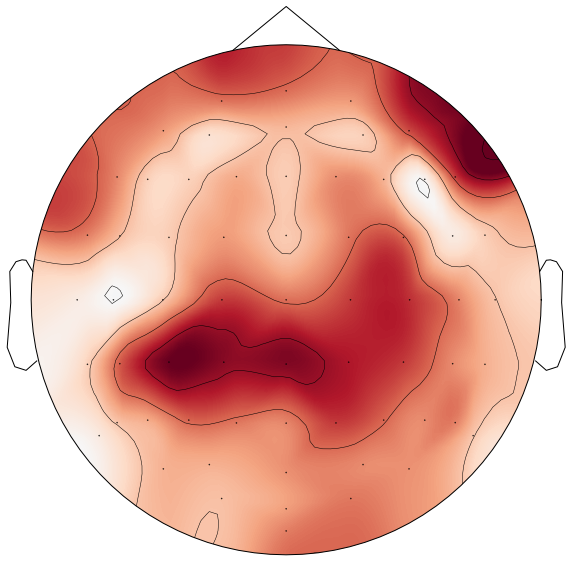

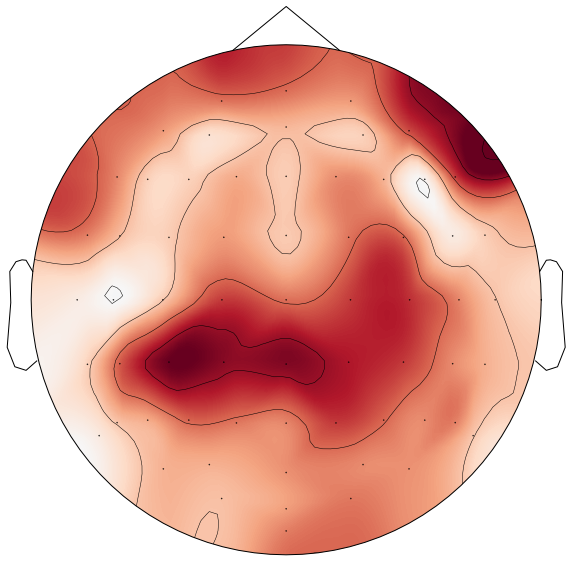

In [6]:
'''
topo-plot 
'''
stat_old_hit_vs_miss, pval_old_hit_vs_miss = ttest_ind(power_all_subj_old_hit.data,power_all_subj_old_miss.data, axis=0, equal_var=False, nan_policy='propagate')


OldHitVsOldMiss = mne.time_frequency.AverageTFR(power_all_subj_old_hit.info, stat_old_hit_vs_miss[:,:,:], power_all_subj_old_hit.times, power_all_subj_old_hit.freqs, nave=power_all_subj_old_hit.data.shape[0]) # take only the freqs from 4-8HZ

plot_tfr_topomap(OldHitVsOldMiss, colorbar=False, size=10, show_names=False, unit=None,  cbar_fmt='%1.2f') # take 0.3s to 0.5s after stim onset


#plt.savefig('/data/sebastian/EEG/neural_analysis/Plots&Graphs/topomap_Stroop_logscaled_final32')

## Cluster Based Permutation test

## across all channels and freqs

In [8]:


'''
Cluster-Based Permutation test over all channels and freqs
'''




start_time = time.time()



# downsampling in case it's needed
power_all_subj_old_hit_down=mne.filter.resample(power_all_subj_old_hit, down=1)
power_all_subj_old_miss_down=mne.filter.resample(power_all_subj_old_miss, down=1)


opj(bids_root,'TFR_RQ3')
ensure_dir(opj(out_dir,'cache'))
mne.set_cache_dir(opj(out_dir,'cache'))


threshold = None
threshold_tfce = dict(start=0, step=0.2)
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([power_all_subj_old_hit_down[:,:,:,:], power_all_subj_old_miss_down[:,:,:,:]], n_jobs=1,
                             n_permutations=1000, threshold=threshold_tfce, tail=0, buffer_size=100, verbose='error', seed=888)


print("--- %s seconds ---" % (time.time() - start_time))
print(cluster_p_values[cluster_p_values<0.05])

--- 2946.9678688049316 seconds ---
[]
